In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [23]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

In [25]:
stock_list = ['Alior Bank', 'Allegro', 'Asseco', 'CCC', 'CD Projekt', 'Cyfrowy Polsat', 'Dino Polska', 'JSW', 'KGHM', 'Lotos', 'LPP', 'Orange Polska', 'PEKAO', 'PGE', 'PGNiG', 'PKN Orlen', 'PKO BP', 'PZU', 'Santander', 'Tauron']

directory = "data/"
stock_data_list = []

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

Loaded file: acp_d.csv
Loaded file: ale_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: cps_d.csv
Loaded file: dnp_d.csv
Loaded file: jsw_d.csv
Loaded file: kgh_d.csv
Loaded file: lpp_d.csv
Loaded file: lts_d.csv
Loaded file: opl_d.csv
Loaded file: peo_d.csv
Loaded file: pge_d.csv
Loaded file: pgn_d.csv
Loaded file: pkn_d.csv
Loaded file: pko_d.csv
Loaded file: pzu_d.csv
Loaded file: san_d.csv
Loaded file: tpe_d.csv


In [26]:
for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

In [27]:
def calculate_technical_indicators(data, rsi_period=10, so_period=14, so_d_period=4, tema_period=10, cgi_period=20, wpi_period=14):
    # rsi_period - number of sessions considered when calculating RSI
    # so_period - number of sessions considered when calculating stochastic oscillator K
    # so_d_period - numbers of sessions considered when calculating moving average of the stochastic oscillator K
    # tema_period - number of sessions considered when calculating TEMA
    # cgi_period - number of sessions considered when calculating CGI
    # wpi_period - number of sessions considered when calculating Williams' Percent Range

    # Moving averages for periods of 10, 30 and 60 days
    data['MovingAverage4'] = data['Close'].rolling(4).mean()
    data['MovingAverage7'] = data['Close'].rolling(7).mean()
    data['MovingAverage20'] = data['Close'].rolling(20).mean()

    # Relative Strength Index RSI
    increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
    increase_difference[increase_difference < 0] = 0
    decrease_difference[decrease_difference > 0] = 0
    roll_increase = increase_difference.ewm(span = rsi_period).mean()
    roll_decrease = decrease_difference.abs().ewm(span = rsi_period).mean()
    RS = roll_increase / roll_decrease
    data['RSI'] = 100 - (100 / (1 + RS))

    # Rate of Change ROC
    data['ROC'] = data['Close'].pct_change()

    # Stochastic Oscillator K
    L14, H14 = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
    data['K'] = (data['Close'] - L14)/(H14 - L14)

    # Moving average of the Stochastic Oscillator D
    data['D'] = data['K'].rolling(so_d_period).mean()

    # Moving Average Convergence / Divergence MACD
    EMA_26 = data['Close'].ewm(26).mean()
    EMA_12 = data['Close'].ewm(12).mean()
    data['MACD'] = EMA_12 - EMA_26

    # MACD Signal Line
    data['MACD_Signal'] = data['MACD'].ewm(9).mean()

    # MACD histogram
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

    # Percentage Price Oscillator PPO
    data['PPO'] =(EMA_12 - EMA_26)/EMA_26

    # Triple Exponential Moving Average TEMA
    SEMA = data['Close'].ewm(tema_period).mean()
    DEMA = SEMA.ewm(tema_period).mean()
    data['TEMA'] = DEMA.ewm(tema_period).mean()

    # Commodity Channel Index CGI
    typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
    MA = typical_price.rolling(cgi_period).mean()
    mean_deviation = (MA - typical_price).abs().rolling(cgi_period).mean()
    data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)

    # Williams' Percent Range
    data['Percent_Range'] = (data['Highest'].rolling(wpi_period).max() - data['Close']) / (data['Highest'].rolling(wpi_period).max() - data['Lowest'].rolling(wpi_period).min())

    return data

In [28]:
def scale_data(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler


In [29]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

**Lerning based on prices and volume only**

In [30]:
scaled_stocks_basic = []
X_scalers_basic = []
Y_scalers_basic = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns='Date'))
  
    scaled_stocks_basic.append(scaled_stock)
    X_scalers_basic.append(X_scaler)
    Y_scalers_basic.append(Y_scaler)
    

In [31]:
X_all_basic = []
Y_all_basic = []
scaled_X_list_basic = []
scaled_Y_list_basic = []

for stock in scaled_stocks_basic:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list_basic.append(np.array(X))
    scaled_Y_list_basic.append(np.array(Y))
    X_all_basic = X_all_basic + X
    Y_all_basic = Y_all_basic + Y

X_all_basic, Y_all_basic = np.array(X_all_basic), np.array(Y_all_basic)
print('Shape of input matrix: ' + str(X_all_basic.shape))
print('Shape of output matrix: ' + str(Y_all_basic.shape))

Shape of input matrix: (76328, 60, 5)
Shape of output matrix: (76328, 5)


In [32]:
from sklearn.model_selection import train_test_split

X_train_basic, X_valid_basic, Y_train_basic, Y_valid_basic = train_test_split(X_all_basic, Y_all_basic, test_size=0.05, shuffle=False)

print('Shape of training input matrix: ' + str(X_train_basic.shape))
print('Shape of training output matrix: ' + str(Y_train_basic.shape))
print('Shape of validation input matrix: ' + str(X_valid_basic.shape))
print('Shape of validation output matrix: ' + str(Y_valid_basic.shape))

Shape of training input matrix: (72511, 60, 5)
Shape of training output matrix: (72511, 5)
Shape of validation input matrix: (3817, 60, 5)
Shape of validation output matrix: (3817, 5)


In [33]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2266/2266 [==============================] - 10s 4ms/step - loss: 0.0089 - val_loss: 4.5861e-04
Epoch 2/10
2266/2266 [==============================] - 10s 4ms/step - loss: 5.4087e-04 - val_loss: 4.2297e-04
Epoch 3/10
2266/2266 [==============================] - 11s 5ms/step - loss: 4.8575e-04 - val_loss: 4.0050e-04
Epoch 4/10
2266/2266 [==============================]

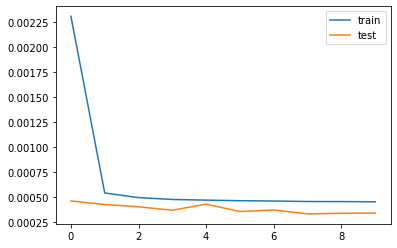

In [34]:
model = Sequential()
model.add(LSTM(32, input_shape=[X_train_basic.shape[1], X_train_basic.shape[2]]))#, return_sequences=True))
#model.add(LSTM(64))
model.add(Dense(10, activation='relu'))
model.add(Dense(Y_train_basic.shape[1]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train_basic, Y_train_basic, epochs=10, validation_data=(X_valid_basic, Y_valid_basic))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

predictions_basic = model.predict(X_valid_basic)
predictions_basic = Y_scalers_basic[0].inverse_transform(predictions_basic)
real_output_basic = Y_scalers_basic[0].inverse_transform(Y_valid_basic)

predicted_data_basic = pd.DataFrame(predictions_basic, columns=['Open_predicted', 'Close_predicted', 'Highest_predicted', 'Lowest_predicted', 'Volume_predicted'])
real_data_basic = pd.DataFrame(real_output_basic, columns=['Open_real', 'Close_real', 'Highest_real', 'Lowest_real', 'Volume_real'])
predictions_basic = pd.concat([real_data_basic, predicted_data_basic], axis=1)
print(predictions_basic[['Close_real', 'Close_predicted']].tail(20))

predictions_basic['Close_difference'] = abs(predictions_basic['Close_real'] - predictions_basic['Close_predicted'])
predictions_basic['Close_difference_percent'] = abs(predictions_basic['Close_real'] - predictions_basic['Close_predicted'])/predictions_basic['Close_real'] * 100

MAPE_basic = predictions_basic['Close_difference_percent'].mean()

print('Predictions MAPE: ' + str(MAPE_basic))

# mae = np.mean(np.abs((predictions[:,1] - scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[:,1])))
# naive_forcast_difference = [abs(scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[i + 1,1] - scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[i,1]) for i in range(scaled_Y_list_basic[0].shape[0] - 1)]
# naive_forcast_mae = sum(naive_forcast_difference) / len(naive_forcast_difference)
# mape = np.mean((np.abs((predictions[:,1] - scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[:,1]))/scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[:,1])*100)
# naive_forcast_mape = (naive_forcast_mae/scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[:,1].mean()) * 100

# print('Prediction mean absolute error: ' + str(mae))
# print('Naive forcast mean absolute error: ' + str(naive_forcast_mae))

# print('Prediction mean absolute percentage error: ' + str(round(mape, 2)) + '%')
# print('Naive forcast mean absolute percentage error: ' + str(round(naive_forcast_mape, 2)) + '%')

      Close_real  Close_predicted
3797   43.150455        44.052654
3798   43.190476        44.215984
3799   43.350559        43.587456
3800   44.711269        44.463902
3801   44.190997        45.131420
3802   42.990371        43.167568
3803   42.950351        43.394432
3804   42.590163        43.751835
3805   42.269996        42.625839
3806   42.390058        42.820004
3807   41.949829        42.699448
3808   41.589641        42.522522
3809   40.909286        41.628014
3810   39.628619        41.186333
3811   38.868222        39.801456
3812   37.987763        37.868019
3813   37.987763        38.089680
3814   37.947742        37.563801
3815   38.588076        38.610504
3816   38.387972        38.607742
Predictions MAPE: 2.3647199482405905


**Lerning based on prices, volume and technical indicators**

In [36]:
from IPython import display
# calculate_technical_indicators parameters -> data, rsi_period=10, so_period=14, so_d_period=4, tema_period=10, cgi_period=20, wpi_period=14
for i in range(len(stock_data_list)):
    stock_data_list[i] = calculate_technical_indicators(stock_data_list[i], rsi_period=60, so_period=5, so_d_period=3, tema_period=4, cgi_period=4, wpi_period=4)
    # moving averages return NaN when the considered period is greater than available data, these rows need to be dropped
    stock_data_list[i] = stock_data_list[i].dropna()

display.display(stock_data_list[0].head(100))

,Date,Open,Highest,Lowest,Close,Volume,MovingAverage4,MovingAverage7,MovingAverage20,RSI,ROC,K,D,MACD,MACD_Signal,MACD_Histogram,PPO,TEMA,CCI,Percent_Range
19,1998-07-01,14.887,14.887,14.887,14.887,200541,14.23250,13.858571,12.91630,73.965805,0.049859,1.000000,1.000000,0.175825,0.063993,0.111832,0.013456,12.724753,10.074074,0.000000
20,1998-07-02,15.160,15.160,15.160,15.160,170204,14.57400,14.115714,13.12075,75.107278,0.018338,1.000000,1.000000,0.215413,0.080995,0.134418,0.016309,12.842207,7.840776,0.000000
21,1998-07-03,15.544,15.544,15.544,15.544,178954,14.94275,14.427714,13.28980,76.599368,0.025330,1.000000,1.000000,0.258999,0.100740,0.158259,0.019384,12.978084,7.385230,0.000000
22,1998-07-06,16.086,16.086,16.086,16.086,204774,15.41925,14.817143,13.43135,78.481622,0.034869,1.000000,1.000000,0.310498,0.123756,0.186742,0.022939,13.134253,7.087901,0.000000
23,1998-07-07,16.526,16.526,16.526,16.526,396111,15.82900,15.207429,13.58690,79.842498,0.027353,1.000000,1.000000,0.366110,0.150092,0.216018,0.026681,13.311802,7.286032,0.000000
24,1998-07-08,16.358,16.358,16.358,16.358,123267,16.12850,15.534429,13.73680,77.897728,-0.010166,0.877013,0.959004,0.408168,0.177895,0.230273,0.029404,13.506224,2.788790,0.171079
25,1998-07-09,15.544,15.544,15.544,15.544,275231,16.12850,15.729286,13.87330,69.426396,-0.049762,0.000000,0.625671,0.419920,0.203770,0.216150,0.030037,13.705309,-7.157234,1.000000
26,1998-07-10,15.544,15.544,15.544,15.544,119449,15.99300,15.823143,14.06160,69.426396,0.000000,0.000000,0.292338,0.428739,0.227655,0.201083,0.030470,13.900751,-6.108844,1.000000
27,1998-07-13,16.631,16.631,16.631,16.631,48999,16.01925,16.033286,14.33960,73.534716,0.069931,1.000000,0.333333,0.466869,0.252898,0.213971,0.032841,14.095875,8.701605,0.000000
28,1998-07-14,17.885,17.885,17.885,17.885,244050,16.40100,16.367714,14.66110,77.190490,0.075401,1.000000,0.666667,0.535738,0.282580,0.253158,0.037152,14.300915,12.646268,0.000000


In [37]:
scaled_stocks = []
X_scalers = []
Y_scalers = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns='Date'))
    scaled_stocks.append(scaled_stock)
    X_scalers.append(X_scaler)
    Y_scalers.append(Y_scaler)

In [38]:
X_all = []
Y_all = []
scaled_X_list = []
scaled_Y_list = []

for stock in scaled_stocks:
  X, Y = prepare_input_and_output(stock)
  scaled_X_list.append(np.array(X))
  scaled_Y_list.append(np.array(Y))
  X_all = X_all + X
  Y_all = Y_all + Y

X_all, Y_all = np.array(X_all), np.array(Y_all)
print('Shape of input matrix: ' + str(X_all.shape))
print('Shape of output matrix: ' + str(Y_all.shape))

Shape of input matrix: (75912, 60, 19)
Shape of output matrix: (75912, 5)


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.05, shuffle=False)

print('Shape of training input matrix: ' + str(X_train.shape))
print('Shape of training output matrix: ' + str(Y_train.shape))
print('Shape of validation input matrix: ' + str(X_valid.shape))
print('Shape of validation output matrix: ' + str(Y_valid.shape))

Shape of training input matrix: (72116, 60, 19)
Shape of training output matrix: (72116, 5)
Shape of validation input matrix: (3796, 60, 19)
Shape of validation output matrix: (3796, 5)


In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                6656      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
Total params: 7,041
Trainable params: 7,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2254/2254 [==============================] - 11s 4ms/step - loss: 0.0055 - val_loss: 4.5816e-04
Epoch 2/10
2254/2254 [==============================] - 8s 4ms/step - loss: 6.9068e-04 - val_loss: 3.8390e-04
Epoch 3/10
2254/2254 [==============================] - 9s 4ms/step - loss: 6.4559e-04 - val_loss: 3.6897e-04
Epoch 4/10
2254/2254 [==============================] -

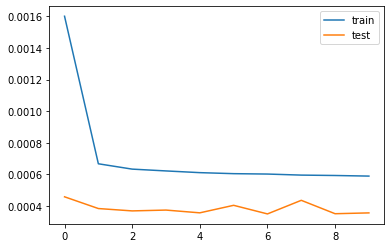

In [41]:
model = Sequential()
model.add(LSTM(32,input_shape=[X_train.shape[1], X_train.shape[2]]))#, return_sequences=True))
model.add(Dense(10, activation='relu'))
model.add(Dense(Y_train.shape[1]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

predictions = model.predict(X_valid)
predictions = Y_scalers[0].inverse_transform(predictions)
real_output = Y_scalers[0].inverse_transform(Y_valid)

predicted_data = pd.DataFrame(predictions, columns=['Open_predicted', 'Close_predicted', 'Highest_predicted', 'Lowest_predicted', 'Volume_predicted'])
real_data = pd.DataFrame(real_output, columns=['Open_real', 'Close_real', 'Highest_real', 'Lowest_real', 'Volume_real'])
predictions = pd.concat([real_data, predicted_data], axis=1)
print(predictions[['Close_real', 'Close_predicted']].tail(20))

predictions['Close_difference'] = abs(predictions['Close_real'] - predictions['Close_predicted'])
predictions['Close_difference_percent'] = abs(predictions['Close_real'] - predictions['Close_predicted'])/predictions['Close_real'] * 100

MAPE = predictions['Close_difference_percent'].mean()

print('Predictions MAPE: ' + str(MAPE))

# mae = np.mean(np.abs((predictions[:,1] - scalers[0].inverse_transform(scaled_Y_list[0])[:,1])))
# naive_forcast_difference = [abs(scalers[0].inverse_transform(scaled_Y_list[0])[i + 1,1] - scalers[0].inverse_transform(scaled_Y_list[0])[i,1]) for i in range(scaled_Y_list[0].shape[0] - 1)]
# naive_forcast_mae = sum(naive_forcast_difference) / len(naive_forcast_difference)
# mape = np.mean((np.abs((predictions[:,1] - scalers[0].inverse_transform(scaled_Y_list[0])[:,1]))/scalers[0].inverse_transform(scaled_Y_list[0])[:,1])*100)
# naive_forcast_mape = (naive_forcast_mae/scalers[0].inverse_transform(scaled_Y_list[0])[:,1].mean()) * 100

# # print('Prediction mean absolute error: ' + str(mae))
# # print('Naive forcast mean absolute error: ' + str(naive_forcast_mae))

# print('Prediction mean absolute percentage error: ' + str(round(mape, 2)) + '%')
# print('Naive forcast mean absolute percentage error: ' + str(round(naive_forcast_mape, 2)) + '%')

      Close_real  Close_predicted
3776   43.150455        43.849815
3777   43.190476        43.895588
3778   43.350559        43.582569
3779   44.711269        44.228542
3780   44.190997        44.653011
3781   42.990371        43.376553
3782   42.950351        43.566452
3783   42.590163        43.651028
3784   42.269996        42.492172
3785   42.390058        42.899311
3786   41.949829        42.696453
3787   41.589641        42.584759
3788   40.909286        41.651657
3789   39.628619        41.293842
3790   38.868222        39.921089
3791   37.987763        38.110386
3792   37.987763        38.003201
3793   37.947742        37.773983
3794   38.588076        38.505970
3795   38.387972        38.803009
Predictions MAPE: 2.4353025245789364
